<a href="https://colab.research.google.com/github/jimmYA-1995/GAN_practice/blob/master/Conditional_GAN_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Colab only
try:
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from skimage.io import imshow
from IPython.display import display

import tensorflow as tf
from tensorflow.keras import Model, layers, Sequential, datasets, optimizers
from tensorflow.keras.datasets import mnist 

In [3]:
np.__version__

'1.17.3'

In [4]:
tf.__version__

'2.0.0'

## Get Mnist Dataset

After import necessary packages, we want to load and preprocess datsets.
Also, visualizing sample images for better understanding.

* load datasets and get types and shapes.
* visualize sample images and labels.
* make tensorflow dataset.

In [5]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

BUFFER_SIZE = x_train.shape[0]
BATCH_SIZE = 32
x_train.dtype, x_train.shape, y_train.dtype, y_train.shape

(dtype('uint8'), (60000, 28, 28), dtype('uint8'), (60000,))

In [6]:
def showX(X):
    int_X_reshape = X.reshape(-1,28,28).swapaxes(0,1).reshape(28,-1)
    display(Image.fromarray(int_X_reshape))

showX(x_train[:20])

In [7]:
y_train[:20]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9],
      dtype=uint8)

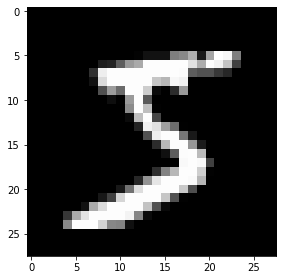

In [8]:
imshow(x_train[0])

In [0]:
def preprocess(x):
    x = (tf.cast(x, tf.float32) - 127.5) / 127.5
    return x[..., None]

ds_train_x = tf.data.Dataset.from_tensor_slices(preprocess(x_train))
ds_train_y = tf.data.Dataset.from_tensor_slices(y_train).map(lambda y: tf.one_hot(y, 10))
ds_train = tf.data.Dataset.zip((ds_train_x, ds_train_y)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Define Generator and Discriminator


## Generator
* use Convolution Transpose for upsampling.
* use Batch Normalization emprically.
* use **Tanh** in the output layer and Leaky_ReLU in the rest of layers.
* **Concatenate noise vector and conditional_label in the  begining**

# Discriminator
* Use common CNN as classifier.
* Concatenate flatted CNN features with conditional labels.

In [0]:
# Define generator
LATENT_DIM = 100
class Generator(Model):
  def __init__(self):
    super().__init__()
    self.fc1 = layers.Dense(7*7*256, use_bias=False, input_shape=(LATENT_DIM,))
    self.bn1 = layers.BatchNormalization()
    # deConV layer
    self.conv2tr_1 = layers.Conv2DTranspose(128, (5,5), strides=(1,1), padding="SAME", use_bias=False)
    self.bn2 = layers.BatchNormalization()
    # deConV layer
    self.conv2tr_2 = layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding="SAME", use_bias=False)
    self.bn3 = layers.BatchNormalization()
    # deConV layer
    self.conv2tr_3 = layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding="SAME", activation="tanh")
    
  @tf.function
  def call(self, inputs, is_training=False):
    _ = layers.concatenate([inputs[1], inputs[0]])
    x = self.fc1(_)
    x = self.bn1(x, training=is_training)
    x = tf.nn.leaky_relu(x)
    x = tf.reshape(x, shape=[-1,7,7,256])
    x = self.conv2tr_1(x)
    x = self.bn2(x, training=is_training)
    x = tf.nn.leaky_relu(x)
    x = self.conv2tr_2(x)
    x = self.bn3(x, training=is_training)
    x = tf.nn.leaky_relu(x)
    
    x = self.conv2tr_3(x)
    
    return x

In [0]:
# DEFINE Descriminator
class Descriminator(Model):
  def __init__(self):
    super().__init__()
    self.conv1 = layers.Conv2D(64, (5,5), strides=2, padding="SAME")
    self.drop1 = layers.Dropout(0.3)
    self.conv2 = layers.Conv2D(128, (5,5), strides=2, padding="SAME")
    self.drop2 = layers.Dropout(0.3)
    self.flatten = layers.Flatten()
    self.fc1 = layers.Dense(50)
    self.bn = layers.BatchNormalization()
    self.fc2 = layers.Dense(1)
  
  @tf.function
  def call(self, inputs, is_training=False):
    x = self.conv1(inputs[0])
    x = tf.nn.leaky_relu(x)
    x = self.drop1(x, training=is_training)
    x = self.conv2(x)
    x = tf.nn.leaky_relu(x)
    x = self.drop2(x, training=is_training)
    x = self.flatten(x)
    x = layers.concatenate([x, inputs[1]])
    x = self.fc1(x)
    x = self.bn(x, training=is_training)
    x = tf.nn.leaky_relu(x)
    x = self.fc2(x)
    
    return x

In [0]:
generator = Generator()
discriminator = Descriminator()
generator.build(input_shape=[(None,10),(None,LATENT_DIM)])
discriminator.build(input_shape=[(None,28,28,1),(None,10)])

# Define Loss and Optimizer
Use cross entropy as loss and Adam optimizer.

In [0]:
# Define both loss function
def generator_loss(generated_output):
  return tf.reduce_mean(tf.losses.binary_crossentropy(tf.ones_like(generated_output), generated_output, from_logits=True))

In [0]:
def discriminator_loss(real_output, generated_output):
  
  real_loss = tf.reduce_mean(tf.losses.binary_crossentropy(tf.ones_like(real_output), real_output, from_logits=True))
  generated_loss = tf.reduce_mean(tf.losses.binary_crossentropy(tf.zeros_like(generated_output), generated_output, from_logits=True))

  total_loss = real_loss + generated_loss

  return total_loss

In [0]:
generator_optimizer = optimizers.Adam(1e-4)
discriminator_optimizer = optimizers.Adam(1e-4)

# Training

In [0]:
EPOCHS = 15
num_examples_to_generate = 20

# Define Metrics
metrics = {}
metrics['G_loss'] = tf.keras.metrics.Mean('generator_loss', dtype=tf.float32)
metrics['D_loss'] = tf.keras.metrics.Mean('discriminator_loss', dtype=tf.float32)

# reuse this vector
random_vector_for_generation = tf.random.normal([num_examples_to_generate,
                                                 LATENT_DIM])
condition_vector_generation = tf.one_hot(list(range(10))+list(range(10)), 10)

In [0]:
@tf.function
def train_step(images, labels):
  noise = tf.random.normal([BATCH_SIZE, LATENT_DIM])
  
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator([noise, labels], is_training=True)

    real_output = discriminator([images, labels], is_training=True)
    generated_output = discriminator([generated_images, labels], is_training=True)

    gen_loss = generator_loss(generated_output)
    disc_loss = discriminator_loss(real_output, generated_output)
    
  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
  
  metrics['G_loss'](gen_loss)
  metrics['D_loss'](disc_loss)

In [0]:
def plot_numBar(images):
  images = np.uint8(images*127.5+128).clip(0, 255)[...,0]
  concat_image = np.transpose(images, [1,0,2])
  concat_image = concat_image.reshape((28,-1))
  display(Image.fromarray(concat_image))

In [19]:
for epoch in range(EPOCHS):
  start_time = time.time()
  for images, labels in ds_train:
    train_step(images, labels)
  
  fake = generator([random_vector_for_generation, condition_vector_generation], is_training=False)
  template = "Epoch {}({:.2f} sec), Generator Loss: {:.4f}, Discriminator  Loss: {:.4f}"
  print(template.format(epoch, time.time()-start_time, metrics["G_loss"].result(),  metrics["D_loss"].result()))
  metrics["G_loss"].reset_states()
  metrics["D_loss"].reset_states()
  
  plot_numBar(fake)

Epoch 0(50.88 sec), Generator Loss: 0.8088, Discriminator  Loss: 1.2162


Epoch 1(45.98 sec), Generator Loss: 0.9266, Discriminator  Loss: 1.1218


Epoch 2(45.93 sec), Generator Loss: 0.8972, Discriminator  Loss: 1.1785


Epoch 3(45.79 sec), Generator Loss: 0.9373, Discriminator  Loss: 1.1395


Epoch 4(45.88 sec), Generator Loss: 1.0014, Discriminator  Loss: 1.0919


Epoch 5(45.99 sec), Generator Loss: 1.0487, Discriminator  Loss: 1.0719


Epoch 6(45.83 sec), Generator Loss: 1.0702, Discriminator  Loss: 1.0688


Epoch 7(45.73 sec), Generator Loss: 1.0810, Discriminator  Loss: 1.0714


Epoch 8(45.63 sec), Generator Loss: 1.0948, Discriminator  Loss: 1.0750


Epoch 9(45.89 sec), Generator Loss: 1.1087, Discriminator  Loss: 1.0751


Epoch 10(45.84 sec), Generator Loss: 1.1198, Discriminator  Loss: 1.0731


Epoch 11(45.74 sec), Generator Loss: 1.1198, Discriminator  Loss: 1.0805


Epoch 12(45.78 sec), Generator Loss: 1.1233, Discriminator  Loss: 1.0847


Epoch 13(45.72 sec), Generator Loss: 1.1279, Discriminator  Loss: 1.0862


Epoch 14(45.80 sec), Generator Loss: 1.1255, Discriminator  Loss: 1.0918


# (Optional) Save model weights and load weights.
only works in colab.

1. Save weights in your google drive for inference in the future.
2. Create a new generator.
3. load weights and compare trained with untrained model.

In [20]:
# Fail if you're not in Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
MODEL_PATH = 'drive/My Drive/Colab Notebooks/mnist_ckpt'
if not os.path.exists(MODEL_PATH):
  os.makedirs(MODEL_PATH)
generator.save_weights(MODEL_PATH, save_format='tf')

In [22]:
new_generator = Generator()
new_generator.build(input_shape=[(None,LATENT_DIM),(None,10)])
noise = tf.random.normal([BATCH_SIZE, LATENT_DIM])
image, label = next(iter(ds_train))

# before load weights
bad_images = new_generator([noise, labels], is_training=True)
plot_numBar(bad_images)

In [23]:
new_generator.load_weights(MODEL_PATH)

# assign digits whatever you want
my_label = list([3,1,2,5,4,8,7,9,0,6])
noise = tf.random.normal([len(my_label), LATENT_DIM])
my_label = tf.one_hot(my_label, 10)

better_image = new_generator([noise, my_label])

plot_numBar(better_image)